In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import json
import pandas as pd

# EDA JSON preliminares

# Cargar los datos

In [16]:
def cargar_datos_json(ruta_archivo):
    with open(ruta_archivo, 'r') as archivo:
        datos = json.load(archivo)
    return pd.DataFrame(datos)

ruta_archivo = 'data_prueba/Aire.10m.BSG.A01-A11.2022/Aire.BSG.A01-A11.2022.json'

df = cargar_datos_json(ruta_archivo)

print(df.head())
print(df.columns)


                                    _id            entityId  \
0  {'$oid': '61cf8f049c67cc6c11509671'}   A01_AVFRANCIA_10m   
1  {'$oid': '61cf8f079c67cc6c11509699'}     A03_MOLISOL_10m   
2  {'$oid': '61cf8f0980a3b62abd24e049'}  A04_PISTASILLA_10m   
3  {'$oid': '61cf8f099c67cc6c115096c1'}  A05_POLITECNIC_10m   
4  {'$oid': '61cf8f0c80a3b62abd24e071'}      A06_VIVERS_10m   

           entityType NO2Value PM10Name  \
0  AirQualityObserved       27     PM10   
1  AirQualityObserved       30     PM10   
2  AirQualityObserved       52     PM10   
3  AirQualityObserved       27     PM10   
4  AirQualityObserved       40      NaN   

                                   PM10Description SO2ValueFlag  \
0  Particulas en suspensión inferiores a 10 micras            V   
1  Particulas en suspensión inferiores a 10 micras            V   
2  Particulas en suspensión inferiores a 10 micras            V   
3  Particulas en suspensión inferiores a 10 micras            V   
4                          

In [17]:
columnas_interes = ['dateObserved', 'entityId', 'NO2Value', 'PM10Value', 'PM25Value', 'O3Value', 'SO2Value', 'NOXValue']

df = df[columnas_interes]

print("Datos filtrados:")
print(df.head())


Datos filtrados:
                            dateObserved            entityId NO2Value  \
0  {'$date': '2022-01-01T00:00:00.000Z'}   A01_AVFRANCIA_10m       27   
1  {'$date': '2022-01-01T00:00:00.000Z'}     A03_MOLISOL_10m       30   
2  {'$date': '2022-01-01T00:00:00.000Z'}  A04_PISTASILLA_10m       52   
3  {'$date': '2022-01-01T00:00:00.000Z'}  A05_POLITECNIC_10m       27   
4  {'$date': '2022-01-01T00:00:00.000Z'}      A06_VIVERS_10m       40   

  PM10Value PM25Value O3Value SO2Value NOXValue  
0        61        42      14        2      NaN  
1        80        59       5        1      NaN  
2        54        65      16        3      NaN  
3        43        44       2        6      NaN  
4       NaN       NaN      15        2      NaN  


In [18]:
percentage_missing = (df.isnull().sum() / len(df)) * 100

percentage_missing

dateObserved     0.000000
entityId         0.000000
NO2Value         0.000000
PM10Value       19.081983
PM25Value       19.081983
O3Value         43.491618
SO2Value        43.491618
NOXValue        95.353378
dtype: float64

In [19]:
def sample_to_csv(df, sample_size=15, output_filename='sample.csv'):
    sample_df = df.sample(n=sample_size, random_state=42)  
    sample_df.to_csv(output_filename, index=False)
    print(f"Archivo '{output_filename}' creado con éxito.")



# Formatear fechas

In [20]:

df['dateObserved'] = pd.to_datetime(df['dateObserved'].str['$date'], errors='coerce')

rango_fechas = (df['dateObserved'].min(), df['dateObserved'].max())
print(f"Rango de fechas: {rango_fechas[0]} - {rango_fechas[1]}")

df.set_index('dateObserved', inplace=True)
df = df.sort_index()

# Verificación de valores nulos en el índice después de la conversión
if df.index.hasnans:
    print("Hay valores nulos en el índice de fecha. Estos serán eliminados para el análisis temporal.")
    df = df[~df.index.isna()]

# Evaluación de la frecuencia de los datos para decidir el resampleo óptimo
# Calculamos la diferencia en días entre observaciones para analizar la periodicidad
delta = df.index.to_series().diff().dropna().dt.days
print("\nFrecuencia de los datos (diferencias de días):")
print(delta.describe())

print("\nPrimeras filas del DataFrame ordenado:")
print(df.head())


Rango de fechas: 2022-01-01 00:00:00+00:00 - 2022-12-31 23:50:00+00:00

Frecuencia de los datos (diferencias de días):
count    546525.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: dateObserved, dtype: float64

Primeras filas del DataFrame ordenado:
                                     entityId NO2Value PM10Value PM25Value  \
dateObserved                                                                 
2022-01-01 00:00:00+00:00   A01_AVFRANCIA_10m       27        61        42   
2022-01-01 00:00:00+00:00     A03_MOLISOL_10m       30        80        59   
2022-01-01 00:00:00+00:00  A04_PISTASILLA_10m       52        54        65   
2022-01-01 00:00:00+00:00  A05_POLITECNIC_10m       27        43        44   
2022-01-01 00:00:00+00:00      A06_VIVERS_10m       40       NaN       NaN   

                          O3Value SO2Value NOXValue  
dateObserved                                         
2022-01


Frecuencia de los datos (diferencias en segundos):
count    546525.000000
mean         57.701660
std         177.110085
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        5400.000000
Name: dateObserved, dtype: float64


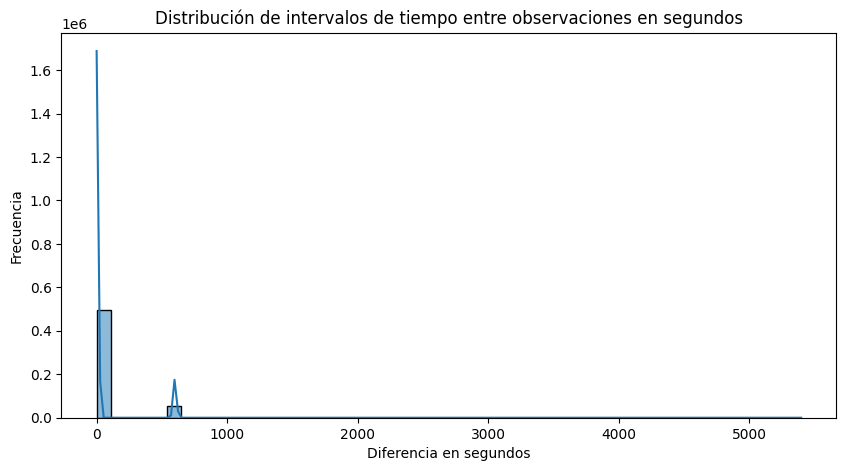

In [21]:
# Cálculo de la frecuencia de las diferencias en segundos
delta = df.index.to_series().diff().dropna().dt.total_seconds()

# Resumen de la frecuencia en segundos entre observaciones
print("\nFrecuencia de los datos (diferencias en segundos):")
print(delta.describe())

# Visualización de la distribución de las diferencias de tiempo para ver patrones
plt.figure(figsize=(10, 5))
sns.histplot(delta, bins=50, kde=True)
plt.title("Distribución de intervalos de tiempo entre observaciones en segundos")
plt.xlabel("Diferencia en segundos")
plt.ylabel("Frecuencia")
plt.show()


# Preparación de datos

In [22]:
print("\nInformación del DataFrame:")
print(df.info())

print("\nCantidad de valores nulos por columna:")
print(df.isnull().sum())



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 546526 entries, 2022-01-01 00:00:00+00:00 to 2022-12-31 23:50:00+00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   entityId   546526 non-null  object
 1   NO2Value   546526 non-null  object
 2   PM10Value  442238 non-null  object
 3   PM25Value  442238 non-null  object
 4   O3Value    308833 non-null  object
 5   SO2Value   308833 non-null  object
 6   NOXValue   25395 non-null   object
dtypes: object(7)
memory usage: 33.4+ MB
None

Cantidad de valores nulos por columna:
entityId          0
NO2Value          0
PM10Value    104288
PM25Value    104288
O3Value      237693
SO2Value     237693
NOXValue     521131
dtype: int64


In [23]:
percentage_missing = (df.isnull().sum() / len(df)) * 100

percentage_missing

entityId      0.000000
NO2Value      0.000000
PM10Value    19.081983
PM25Value    19.081983
O3Value      43.491618
SO2Value     43.491618
NOXValue     95.353378
dtype: float64

In [24]:
filtro = ['entityId', 'NO2Value', 'PM10Value', 'PM25Value']

df = df[filtro]

In [25]:
sample_to_csv(df, 15, 'muestra_aleatoria.csv')

Archivo 'muestra_aleatoria.csv' creado con éxito.


In [26]:
entity_distribution = df['entityId'].value_counts()

pollutants_summary = df[['NO2Value', 'PM10Value', 'PM25Value']].describe()

entity_distribution, pollutants_summary

(entityId
 A04_PISTASILLA_10m        52476
 A07_VALENCIACENTRE_10m    52456
 A09_CABANYAL_10m          52394
 A01_AVFRANCIA_10m         52353
 A06_VIVERS_10m            52250
 A02_BULEVARDSUD_10m       52038
 A05_POLITECNIC_10m        51696
 A08_DR_LLUCH_10m          50025
 A03_MOLISOL_10m           48020
 A10_OLIVERETA_10m         41911
 A11_PATRAIX_10m           40907
 Name: count, dtype: int64,
        NO2Value PM10Value PM25Value
 count    546526    442238    442238
 unique      255       484       274
 top           3        19         8
 freq      29478     13930     27426)

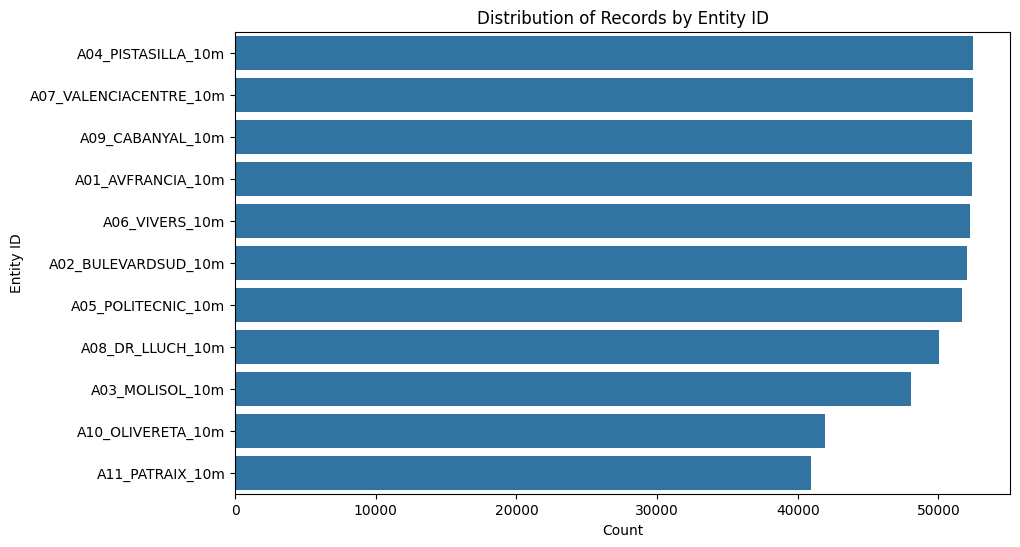

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for clarity
plt.style.use('default')

# 1. Visualize the distribution of records by entityId
plt.figure(figsize=(10, 6))
sns.countplot(y='entityId', data=df, order=entity_distribution.index)
plt.title("Distribution of Records by Entity ID")
plt.xlabel("Count")
plt.ylabel("Entity ID")
plt.show()

# 2. Visualize distribution of NO2, PM10, and PM25 values
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

sns.histplot(df['NO2Value'], bins=10, kde=True, ax=axes[0])
axes[0].set_title('Distribution of NO2 Values')
axes[0].set_xlabel('NO2 Value')
axes[0].set_ylabel('Frequency')

sns.histplot(df['PM10Value'].dropna(), bins=10, kde=True, ax=axes[1])
axes[1].set_title('Distribution of PM10 Values')
axes[1].set_xlabel('PM10 Value')
axes[1].set_ylabel('Frequency')

sns.histplot(df['PM25Value'].dropna(), bins=10, kde=True, ax=axes[2])
axes[2].set_title('Distribution of PM25 Values')
axes[2].set_xlabel('PM25 Value')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [14]:
df[['PM10Value', 'PM25Value']] = df[['PM10Value', 'PM25Value']].interpolate(method='linear')

TypeError: Cannot interpolate with all object-dtype columns in the DataFrame. Try setting at least one column to a numeric dtype.

In [17]:
df['PM10Value'] = pd.to_numeric(df['PM10Value'], errors='coerce')

df['PM10Value'] = df['PM10Value'].interpolate(method='linear')


In [18]:
df['PM25Value'] = pd.to_numeric(df['PM10Value'], errors='coerce')

df['PM25Value'] = df['PM10Value'].interpolate(method='linear')

In [27]:
df['NO2Value'] = pd.to_numeric(df['NO2Value'], errors='coerce')


In [28]:
df.describe()

,NO2Value,PM10Value,PM25Value
count,546526.000000,546526.000000,546526.000000
mean,19.743381,24.442852,19.743381
std,18.105103,23.818838,18.105103
min,0.000000,0.000000,0.000000
25%,7.000000,13.000000,7.000000
50%,14.000000,21.000000,14.000000
75%,27.000000,31.000000,27.000000
max,545.000000,3613.000000,545.000000


# Preguntas en el EDA

Distribución y representación:

¿Hay barrios que presentan niveles consistentemente altos o bajos de ciertos contaminantes?
¿La representación de cada contaminante es balanceada entre los diferentes barrios?
Evolución temporal de los contaminantes:

¿Cómo varían los niveles de cada contaminante a lo largo del tiempo y entre los barrios?
¿Existen patrones temporales que indiquen aumentos o disminuciones en ciertas horas del día, días específicos de la semana o estacionalidad?
Correlación entre contaminantes:

¿Existe correlación entre los niveles de NO2, PM10 y PM2.5? Esto podría dar insights sobre fuentes comunes de contaminación en ciertos barrios o momentos.
Comparación de valores medios por barrio:

¿Cuáles barrios tienen las medias más altas o bajas para cada contaminante? Esto ayuda a identificar áreas potencialmente más contaminadas.

Contaminantes por barrio

Contaminantes a lo largo del tiempo

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

sns.boxplot(x='entityId', y='NO2Value', data=df, ax=axes[0])
axes[0].set_title('Concentración de NO2 por Barrio')
axes[0].set_xlabel('Barrio (entityId)')
axes[0].set_ylabel('Valor NO2')

sns.boxplot(x='entityId', y='PM10Value', data=df, ax=axes[1])
axes[1].set_title('Concentración de PM10 por Barrio')
axes[1].set_xlabel('Barrio (entityId)')
axes[1].set_ylabel('Valor PM10')

sns.boxplot(x='entityId', y='PM25Value', data=df, ax=axes[2])
axes[2].set_title('Concentración de PM2.5 por Barrio')
axes[2].set_xlabel('Barrio (entityId)')
axes[2].set_ylabel('Valor PM2.5')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Asegúrate de que el timestamp esté en formato de fecha
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Evolución de NO2, PM10 y PM2.5 a lo largo del tiempo
fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Evolución de NO2
sns.lineplot(data=df, x='timestamp', y='NO2Value', hue='entityId', ax=ax[0], marker='o')
ax[0].set_title('Evolución de NO2 en el tiempo')
ax[0].set_xlabel('Tiempo')
ax[0].set_ylabel('Valor NO2')

# Evolución de PM10
sns.lineplot(data=df, x='timestamp', y='PM10Value', hue='entityId', ax=ax[1], marker='o')
ax[1].set_title('Evolución de PM10 en el tiempo')
ax[1].set_xlabel('Tiempo')
ax[1].set_ylabel('Valor PM10')

# Evolución de PM2.5
sns.lineplot(data=df, x='timestamp', y='PM25Value', hue='entityId', ax=ax[2], marker='o')
ax[2].set_title('Evolución de PM2.5 en el tiempo')
ax[2].set_xlabel('Tiempo')
ax[2].set_ylabel('Valor PM2.5')

plt.tight_layout()
plt.show()
